# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

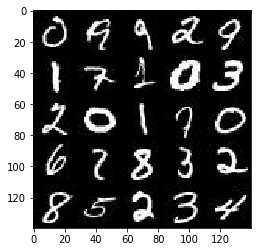

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

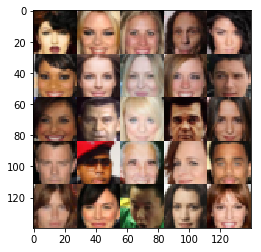

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real') 
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
            
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)


    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_shape = data_shape[1:]
        
    input_real, input_z, lr_rate = model_inputs(*image_shape, z_dim)
    
    out_channel_dim = image_shape[-1]
    
    d_loss, g_loss = model_loss(input_real, input_z,out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    n_images = 25
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Sample random noise for G
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr_rate:learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr_rate:learning_rate}) # TODO: run extra g
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.3133... Generator Loss: 0.0092
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 8.1230
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 2.3811
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 3.2143
Epoch 1/2... Discriminator Loss: 0.5137... Generator Loss: 3.9868
Epoch 1/2... Discriminator Loss: 0.4948... Generator Loss: 2.8142
Epoch 1/2... Discriminator Loss: 2.8872... Generator Loss: 0.1496
Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 1.6086
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 3.2465
Epoch 1/2... Discriminator Loss: 0.5956... Generator Loss: 4.4137


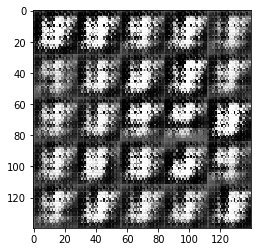

Epoch 1/2... Discriminator Loss: 0.4724... Generator Loss: 3.4843
Epoch 1/2... Discriminator Loss: 0.4688... Generator Loss: 2.7977
Epoch 1/2... Discriminator Loss: 0.4134... Generator Loss: 4.0579
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 8.0057
Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 2.4298
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 3.8163
Epoch 1/2... Discriminator Loss: 0.5660... Generator Loss: 2.5262
Epoch 1/2... Discriminator Loss: 0.5426... Generator Loss: 4.1135
Epoch 1/2... Discriminator Loss: 3.6444... Generator Loss: 15.2098
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 3.3066


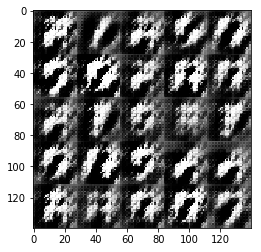

Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 2.9967
Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 3.3697
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 4.0903
Epoch 1/2... Discriminator Loss: 0.4118... Generator Loss: 8.7933
Epoch 1/2... Discriminator Loss: 0.4166... Generator Loss: 3.5950
Epoch 1/2... Discriminator Loss: 0.4202... Generator Loss: 2.8628
Epoch 1/2... Discriminator Loss: 0.5123... Generator Loss: 3.0165
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 5.1936
Epoch 1/2... Discriminator Loss: 0.5055... Generator Loss: 2.5142
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 6.5958


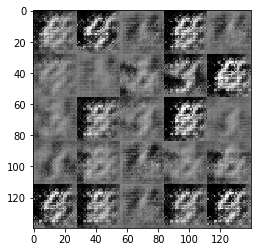

Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 3.4715
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 4.8042
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 4.4064
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 2.2634
Epoch 1/2... Discriminator Loss: 0.6447... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 5.3003
Epoch 1/2... Discriminator Loss: 0.4887... Generator Loss: 3.4916
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 2.0788
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 3.4462
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.2263


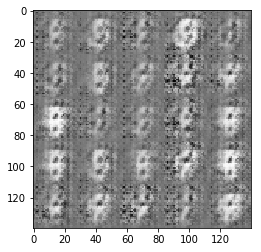

Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.4075
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 3.0549
Epoch 1/2... Discriminator Loss: 0.3721... Generator Loss: 4.9796
Epoch 1/2... Discriminator Loss: 0.5126... Generator Loss: 2.1109
Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 2.4176
Epoch 1/2... Discriminator Loss: 1.8010... Generator Loss: 0.3776
Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 3.8813
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 3.6428
Epoch 2/2... Discriminator Loss: 0.4606... Generator Loss: 3.4016
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.4632


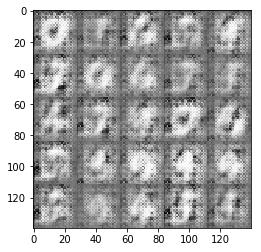

Epoch 2/2... Discriminator Loss: 0.4813... Generator Loss: 2.6175
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 2.0188
Epoch 2/2... Discriminator Loss: 1.7088... Generator Loss: 6.7752
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 2.0875
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 5.2157
Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 2.1061
Epoch 2/2... Discriminator Loss: 0.4281... Generator Loss: 3.4913
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.5144
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 2.4806
Epoch 2/2... Discriminator Loss: 0.3812... Generator Loss: 5.6237


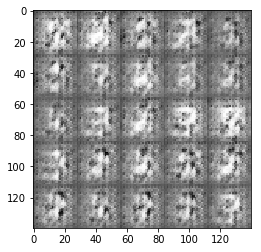

Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 4.0156
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 2.0773
Epoch 2/2... Discriminator Loss: 0.4788... Generator Loss: 2.5234
Epoch 2/2... Discriminator Loss: 0.4042... Generator Loss: 3.3959
Epoch 2/2... Discriminator Loss: 0.4177... Generator Loss: 3.0561
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 3.2366
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 5.6762
Epoch 2/2... Discriminator Loss: 0.4603... Generator Loss: 2.5793
Epoch 2/2... Discriminator Loss: 4.0759... Generator Loss: 0.0567


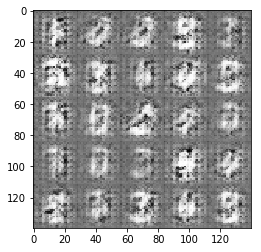

Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 3.4333
Epoch 2/2... Discriminator Loss: 0.5514... Generator Loss: 2.6246
Epoch 2/2... Discriminator Loss: 0.4695... Generator Loss: 2.5601
Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 2.3926
Epoch 2/2... Discriminator Loss: 0.4202... Generator Loss: 3.3492
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 3.7765
Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 2.8508
Epoch 2/2... Discriminator Loss: 2.1271... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 0.5253... Generator Loss: 2.3049
Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 2.7044


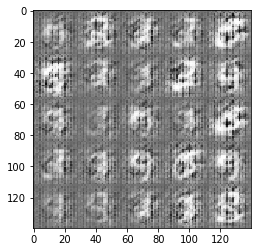

Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 3.1037
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 3.4883
Epoch 2/2... Discriminator Loss: 0.3917... Generator Loss: 3.6952
Epoch 2/2... Discriminator Loss: 0.3758... Generator Loss: 3.9436
Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 3.8184
Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.2913
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 3.7292
Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 2.6350
Epoch 2/2... Discriminator Loss: 0.3752... Generator Loss: 4.9482
Epoch 2/2... Discriminator Loss: 0.3679... Generator Loss: 4.5813


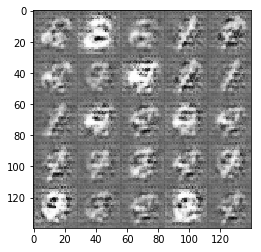

Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 4.4446
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 2.9362
Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 4.1441


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.4597... Generator Loss: 0.0199
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 9.0703
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.2172
Epoch 1/1... Discriminator Loss: 0.6163... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 0.6138... Generator Loss: 6.5863
Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 2.6771
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 3.2847


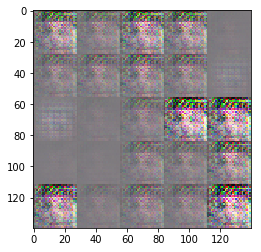

Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 4.5094
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 3.2085
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 4.3526
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 4.2407
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 3.6676
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 0.5837... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 2.1660
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.2949
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6041


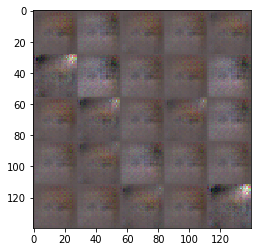

Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 2.8901
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 2.7277... Generator Loss: 2.8100
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 1.2419


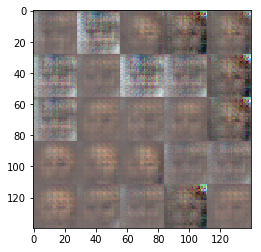

Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.6157
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 3.2732
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.5903
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 3.4488
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 3.2080
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 2.5849
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.7291


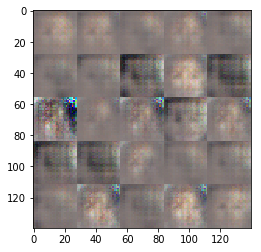

Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 3.5906
Epoch 1/1... Discriminator Loss: 2.0945... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.6174
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.6417
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.2805
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9948


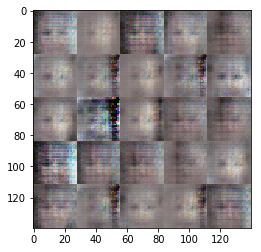

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 2.3005
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.9875


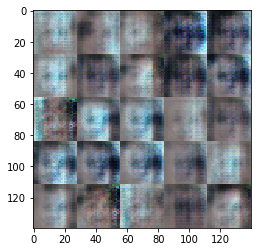

Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 4.1881
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 2.2955
Epoch 1/1... Discriminator Loss: 1.7791... Generator Loss: 3.3403
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9285


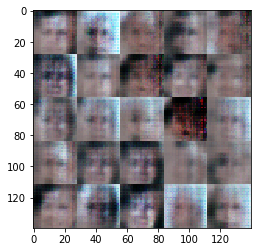

Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 0.4576... Generator Loss: 3.5186
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 2.0741
Epoch 1/1... Discriminator Loss: 0.3998... Generator Loss: 4.6758
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 1.2868


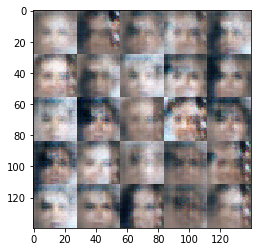

Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 1.9270
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.5748
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 2.1499
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.5087
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 2.3599
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 2.0581


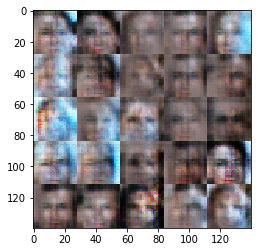

Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.6807
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.7577
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 2.2572
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.5080


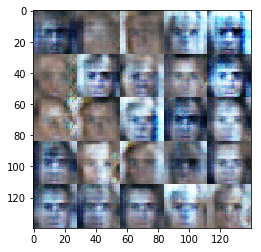

Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 2.0530... Generator Loss: 2.8739
Epoch 1/1... Discriminator Loss: 2.4353... Generator Loss: 2.2110
Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.6909
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.9745
Epoch 1/1... Discriminator Loss: 0.6541... Generator Loss: 1.9363
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.0541
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 2.2584... Generator Loss: 1.3781


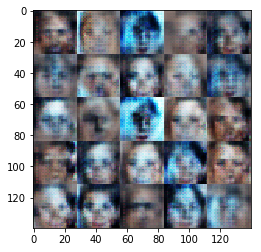

Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.5753
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.9901
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.9187


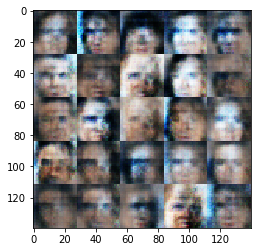

Epoch 1/1... Discriminator Loss: 2.0660... Generator Loss: 3.1462
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 2.6237
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 2.9133
Epoch 1/1... Discriminator Loss: 2.7095... Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7537


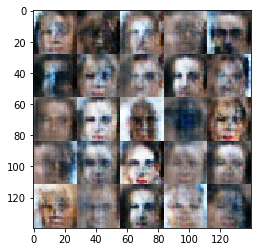

Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.4325
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.8419
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8835


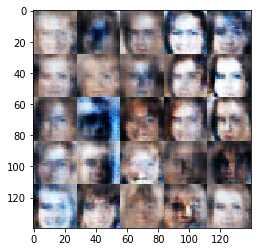

Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.9805
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.7690


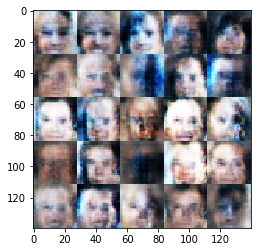

Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.8401
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 2.3817


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.